# **Libraries & Constants**

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Softmax, BatchNormalization, Dropout, Conv2D, MaxPool2D, Embedding, Reshape, Flatten, LSTM, GRU, SimpleRNN, Concatenate, concatenate, RepeatVector, TimeDistributed, Bidirectional
# from keras.layers.merge import concatenate
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax, Nadam, SGD
from tensorflow.keras import Model
from tensorflow.keras.optimizers.schedules import InverseTimeDecay, ExponentialDecay
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences #from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
import os
import string
from google.colab import drive

In [2]:
drive.mount('/content/drive')
dataPath="/content/drive/MyDrive/AI Projects/Arabic Broken Plural/data"

Mounted at /content/drive


# **Preprocessing**

In [ ]:
train_csv = pd.read_csv(dataPath+"/train_pairs_all.csv")
dev_csv = pd.read_csv(dataPath+"/dev_pairs_all.csv")
test_csv = pd.read_csv(dataPath+"/test_pairs_all.csv")

train_csv.head()

,lemma,inflection,NUM,GEN,RAT,lex_freq,B/S,SING_PATT,PL_PATT,ROOT,FREQ
0,Eamal,>aEomAl,PL,m,i,49,B,1a2a3,>a1o2A3,E.m.l,49
1,hadaf,>ahodAf,PL,m,i,42,B,1a2a3,>a1o2A3,h.d.f,42
2,EuDow,>aEoDA',PL,m,r,46,B,1u2ow,>a1o2A',E.D.#,39
3,jihAz,>ajohizap,PL,m,i,41,B,1i2A3,>a1o2i3ap,j.h.z,35
4,Hukom,>aHokAm,PL,m,i,35,B,1u2o3,>a1o2A3,H.k.m,35


In [ ]:
# Label encoder for encoding gender and rational features
# 'B' class: 0      'S' class: 1
categorical_attr = ['GEN', 'RAT', 'B/S']

le = LabelEncoder()
train_csv[categorical_attr] = train_csv[categorical_attr].apply(le.fit_transform, axis=0)

le = LabelEncoder()
test_csv[categorical_attr] = test_csv[categorical_attr].apply(le.fit_transform, axis=0)

le = LabelEncoder()
dev_csv[categorical_attr] = dev_csv[categorical_attr].apply(le.fit_transform, axis=0)

train_csv.head()

,lemma,inflection,NUM,GEN,RAT,lex_freq,B/S,SING_PATT,PL_PATT,ROOT,FREQ
0,Eamal,>aEomAl,PL,1,0,49,0,1a2a3,>a1o2A3,E.m.l,49
1,hadaf,>ahodAf,PL,1,0,42,0,1a2a3,>a1o2A3,h.d.f,42
2,EuDow,>aEoDA',PL,1,1,46,0,1u2ow,>a1o2A',E.D.#,39
3,jihAz,>ajohizap,PL,1,0,41,0,1i2A3,>a1o2i3ap,j.h.z,35
4,Hukom,>aHokAm,PL,1,0,35,0,1u2o3,>a1o2A3,H.k.m,35


In [ ]:
def getNumpyData(dataFrame):
  '''
  Output type->List : 0:lamma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational 
  '''
  data = [] # 0:lamma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational 
  data.append(dataFrame['lemma'].to_numpy())
  data.append(dataFrame['SING_PATT'].to_numpy())

  root = dataFrame['ROOT'].to_numpy()
  # delete dot sign(.) in root feature
  for i in range(len(root)): root[i] = root[i].replace(".","")
  data.append(root)

  data.append(dataFrame['inflection'].to_numpy())
  data.append(dataFrame['PL_PATT'].to_numpy())
  data.append(dataFrame['B/S'].to_numpy())
  data.append(dataFrame['GEN'].to_numpy())
  data.append(dataFrame['RAT'].to_numpy())
  print(data[0].shape)
  return data

trainData = getNumpyData(train_csv)
devData = getNumpyData(dev_csv)
testData = getNumpyData(test_csv)

(2862,)
(1151,)
(1103,)


In [ ]:
# generate character encoding
oov_token = 'not available char'
char_index = {oov_token: 0}

def updateCharIndex(data):
  global char_index
  # encode input with encoding character set
  for i in range(len(data[0])):
      chars = list(data[0][i]) + list(data[1][i]) + list(data[3][i]) + list(data[4][i])
      for c in chars:
          if c not in char_index:
              char_index[c] = len(char_index)

updateCharIndex(trainData)
print(len(char_index))
print(char_index)

50
{'not available char': 0, 'E': 1, 'a': 2, 'm': 3, 'l': 4, '1': 5, '2': 6, '3': 7, '>': 8, 'o': 9, 'A': 10, 'h': 11, 'd': 12, 'f': 13, 'u': 14, 'D': 15, 'w': 16, "'": 17, 'j': 18, 'i': 19, 'z': 20, 'p': 21, 'H': 22, 'k': 23, 'n': 24, 'S': 25, 'r': 26, '4': 27, 'q': 28, '~': 29, 'y': 30, 't': 31, 's': 32, '<': 33, 'b': 34, 'v': 35, '|': 36, 'T': 37, '}': 38, 'Z': 39, '{': 40, '&': 41, '$': 42, 'x': 43, 'N': 44, 'W': 45, '*': 46, 'g': 47, 'Y': 48, 'F': 49}


In [ ]:
# encode words with character encoder
def encodeWord(word, dic=char_index, oov=oov_token):
    return [dic[c] if c in dic else dic[oov] for c in list(word)]

# encode data and get maximum length of features
def getEncodedData(data):
  '''
  Output type->List : 0:lamma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational 
  '''

  data_encoded = np.copy(data)
  data_encoded[0] = np.array([encodeWord(each) for each in data[0]])
  data_encoded[1] = np.array([encodeWord(each) for each in data[1]])
  data_encoded[2] = np.array([encodeWord(each) for each in data[2]])
  data_encoded[3] = np.array([encodeWord(each) for each in data[3]])
  data_encoded[4] = np.array([encodeWord(each) for each in data[4]])

  lemma_max_len = max([len(each) for each in data_encoded[0]])
  root_max_len = max([len(each) for each in data_encoded[2]])
  inflection_max_len = max([len(each) for each in data_encoded[3]])

  return data_encoded, lemma_max_len, root_max_len, inflection_max_len



trainData_encoded, lemma_max_len, root_max_len, inflection_max_len = getEncodedData(trainData)
devData_encoded, _, _, _  = getEncodedData(devData)
testData_encoded, _, _, _ = getEncodedData(testData)

print('lemma shape train: ', trainData_encoded[0].shape)
print('lemma shape dev: ', devData_encoded[0].shape)
print('lemma shape test: ', testData_encoded[0].shape)
print('max length in lemma elements: ', lemma_max_len)
print('max length in root elements: ', root_max_len)
print('max length in inflection elements: ', inflection_max_len)

lemma shape train:  (2862,)
lemma shape dev:  (1151,)
lemma shape test:  (1103,)
max length in lemma elements:  17
max length in root elements:  4
max length in inflection elements:  18


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=

In [ ]:
# ADD padding to sample
# 0:lamma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational 
def getPaddedData(encodedData, lemma_max_len, root_max_len, inflection_max_len):
  data_pad = []
  data_pad.append(np.array(pad_sequences(encodedData[0], maxlen=lemma_max_len, padding='post'))) 
  data_pad.append(np.array(pad_sequences(encodedData[1], maxlen=lemma_max_len, padding='post')))
  data_pad.append(np.array(pad_sequences(encodedData[2], maxlen=root_max_len, padding='post')))
  data_pad.append(np.array(pad_sequences(encodedData[3], maxlen=inflection_max_len, padding='post')))
  data_pad.append(np.array(pad_sequences(encodedData[4], maxlen=inflection_max_len, padding='post')))
  data_pad.append(encodedData[5])
  data_pad.append(encodedData[6])
  data_pad.append(encodedData[7])

  return data_pad

trainData_pad = getPaddedData(trainData_encoded, lemma_max_len, root_max_len, inflection_max_len)
devData_pad = getPaddedData(devData_encoded, lemma_max_len, root_max_len, inflection_max_len)
testData_pad = getPaddedData(testData_encoded, lemma_max_len, root_max_len, inflection_max_len)

print('lemma with pad shape train: ', trainData_pad[0].shape)
print('lemma with pad shape dev: ', devData_pad[0].shape)
print('lemma with pad shape test: ', testData_pad[0].shape)

lemma with pad shape train:  (2862, 17)
lemma with pad shape dev:  (1151, 17)
lemma with pad shape test:  (1103, 17)


## **Create inputs of neural network**

In [ ]:
# 0:lamma | 1:singular pattern | 2:root |3:inflection | 4:plural pattern | 5:plural type(B/S) | 6:gender | 7:rational 
# create train set
X_train_lemma = trainData_pad[0]  # lemma feature
X_train_singularPattern = trainData_pad[1]  # singular pattern feature
X_train_root = trainData_pad[2]  # root feature
X_train_genRat = np.stack((trainData_pad[6], trainData_pad[7]), axis=-1)  # gender & rational features

y_train_class = trainData_pad[5].reshape((trainData_pad[5].shape[0], -1))  # broken or sound classes
y_train_plPattern = trainData_pad[4]  # plural pattern
y_train_inflection = trainData_pad[3]  # inflection

# create dev set
X_dev_lemma = devData_pad[0]  # lemma feature
X_dev_singularPattern = devData_pad[1]  # singular pattern feature
X_dev_root = devData_pad[2]  # root feature
X_dev_genRat = np.stack((devData_pad[6], devData_pad[7]), axis=-1)  # gender & rational features

y_dev_class = devData_pad[5].reshape((devData_pad[5].shape[0], -1))  # broken or sound classes
y_dev_plPattern = devData_pad[4]  # plural pattern
y_dev_inflection = devData_pad[3]  # inflection

# create test set
X_test_lemma = testData_pad[0]  # lemma feature
X_test_singularPattern = testData_pad[1]  # singular pattern feature
X_test_root = testData_pad[2]  # root feature
X_test_genRat = np.stack((testData_pad[6], testData_pad[7]), axis=-1)  # gender & rational features

y_test_class = testData_pad[5].reshape((testData_pad[5].shape[0], -1))  # broken or sound classes
y_test_plPattern = testData_pad[4]  # plural pattern
y_test_inflection = testData_pad[3]  # inflection

print('X_train_lemma shape: ', X_train_lemma.shape)
print('X_train_singularPattern shape: ', X_train_singularPattern.shape)
print('X_train_root shape: ', X_train_root.shape)
print('X_train_genRat shape: ', X_train_genRat.shape)
print('y_train_class shape: ', y_train_class.shape)
print('y_train_plPattern shape: ', y_train_plPattern.shape)
print('y_train_unflection shape: ', y_train_inflection.shape)

X_train_lemma shape:  (2862, 17)
X_train_singularPattern shape:  (2862, 17)
X_train_root shape:  (2862, 4)
X_train_genRat shape:  (2862, 2)
y_train_class shape:  (2862, 1)
y_train_plPattern shape:  (2862, 18)
y_train_unflection shape:  (2862, 18)


In [ ]:
# Convert to ONE-HOT encoding
X_train_lemma_OH = to_categorical(X_train_lemma, len(char_index))
X_train_singularPattern_OH = to_categorical(X_train_singularPattern, len(char_index))
X_train_root_OH = to_categorical(X_train_root, len(char_index))

X_dev_lemma_OH = to_categorical(X_dev_lemma, len(char_index))
X_dev_singularPattern_OH = to_categorical(X_dev_singularPattern, len(char_index))
X_dev_root_OH = to_categorical(X_dev_root, len(char_index))

X_test_lemma_OH = to_categorical(X_test_lemma, len(char_index))
X_test_singularPattern_OH = to_categorical(X_test_singularPattern, len(char_index))
X_test_root_OH = to_categorical(X_test_root, len(char_index))

y_train_plPattern_OH = to_categorical(y_train_plPattern, len(char_index))
y_dev_plPattern_OH = to_categorical(y_dev_plPattern, len(char_index))
y_test_plPattern_OH = to_categorical(y_test_plPattern, len(char_index))

y_train_inflection_OH = to_categorical(y_train_inflection, len(char_index))
y_dev_inflection_OH = to_categorical(y_dev_inflection, len(char_index))
y_test_inflection_OH = to_categorical(y_test_inflection, len(char_index))

print(X_train_lemma_OH.shape)
print(X_train_singularPattern_OH.shape)
print(X_train_root_OH.shape)
print(y_train_plPattern_OH.shape)
print(y_train_inflection_OH.shape)

(2862, 17, 50)
(2862, 17, 50)
(2862, 4, 50)
(2862, 18, 50)
(2862, 18, 50)


In [ ]:
# covern numerical inputs to int32
X_train_genRat = np.asarray(X_train_genRat).astype('int32')
X_dev_genRat = np.asarray(X_dev_genRat).astype('int32')
X_test_genRat = np.asarray(X_test_genRat).astype('int32')

y_train_class = np.asarray(y_train_class).astype('int32')
y_dev_class = np.asarray(y_dev_class).astype('int32')
y_test_class = np.asarray(y_test_class).astype('int32')

# **Helper Functions**

In [ ]:
def binaryConversion(arr, threshold=0.5):
  tmp = np.zeros_like(arr)
  tmp[arr > threshold] = 1
  return tmp

def reportResult(model, history, X_test, y_test):

    # best models based on acc or loss in tarin set or test set
    testHistory = list(
        map(lambda x, y: [x, y], history['val_accuracy'], history['val_loss']))
    print(
        f"best model based on min test set loss:  acc= {min(testHistory, key = lambda k: k[1])[0]}  loss= {min(testHistory, key = lambda k: k[1])[1]}")
    print(
        f"best model based on max test set accuracy:  acc= {max(testHistory, key = lambda k: k[0])[0]}  loss= {max(testHistory, key = lambda k: k[0])[1]}")

    print("\nevaluate dataset with best model based on maximum test set accuracy")
    print("evaluate test set = ", model.evaluate(X_test, y_test, verbose=0))

    y_test_pred = model.predict(X_test)
    y_test_pred = binaryConversion(y_test_pred)

    # confusion matrix and precision, recall and f1 report
    print('-'*30, 'metrics for test set', '-'*30)
    print("confusion matrix: \n", metrics.confusion_matrix(y_test, y_test_pred))
    print(metrics.classification_report(y_test,
          y_test_pred, digits=3, target_names=['Broken', 'Sound']))
    

# **Classification Models**

In [ ]:
path = '/content/drive/MyDrive/AI Projects/Arabic Broken Plural/Results/Classification Models'

In [ ]:
lemma_length = X_train_lemma_OH.shape[1] #17
encode_size = X_train_lemma_OH.shape[2] #50
genRat_length = X_train_genRat.shape[1] #2

epochs = 100
batch_size = 64

## **Model 1**

In [ ]:
input_lemma = Input(shape=(lemma_length, encode_size))
input_genRat = Input(shape=(genRat_length,))


lstm = Bidirectional(LSTM(256))(input_lemma)

c = Concatenate(axis=1)([lstm, input_genRat])

d = Dense(256, activation='relu')(c)
d = Dense(64, activation='relu')(d)
# d = Dense(32, activation='relu')(d)

output = Dense(1, activation='sigmoid')(d)
model = Model(inputs=[input_lemma, input_genRat], outputs=output)

checkpoint_filepath = path + '/model 1/model 1.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

model.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
  history = model.fit([X_train_lemma_OH, X_train_genRat], y_train_class, batch_size=batch_size, epochs=epochs, 
                      verbose=1, callbacks=[checkpoint], validation_data=([X_dev_lemma_OH, X_dev_genRat], y_dev_class)).history

Epoch 1/100
45/45 [==============================] - 10s 52ms/step - loss: 0.5401 - accuracy: 0.7170 - val_loss: 0.4464 - val_accuracy: 0.7802
Epoch 2/100
45/45 [==============================] - 1s 12ms/step - loss: 0.4492 - accuracy: 0.7694 - val_loss: 0.4254 - val_accuracy: 0.7767
Epoch 3/100
45/45 [==============================] - 1s 13ms/step - loss: 0.4245 - accuracy: 0.7890 - val_loss: 0.4097 - val_accuracy: 0.7932
Epoch 4/100
45/45 [==============================] - 1s 11ms/step - loss: 0.4047 - accuracy: 0.8071 - val_loss: 0.3618 - val_accuracy: 0.8288
Epoch 5/100
45/45 [==============================] - 0s 11ms/step - loss: 0.3688 - accuracy: 0.8288 - val_loss: 0.3615 - val_accuracy: 0.8323
Epoch 6/100
45/45 [==============================] - 1s 12ms/step - loss: 0.3576 - accuracy: 0.8319 - val_loss: 0.3173 - val_accuracy: 0.8549
Epoch 7/100
45/45 [==============================] - 0s 9ms/step - loss: 0.3287 - accuracy: 0.8501 - val_loss: 0.3012 - val_accuracy: 0.8480
Epoch 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 17, 50)]     0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 512)          628736      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 514)          0           ['bidirectional[0][0]',          
                                                                  'input_2[0][0]']            

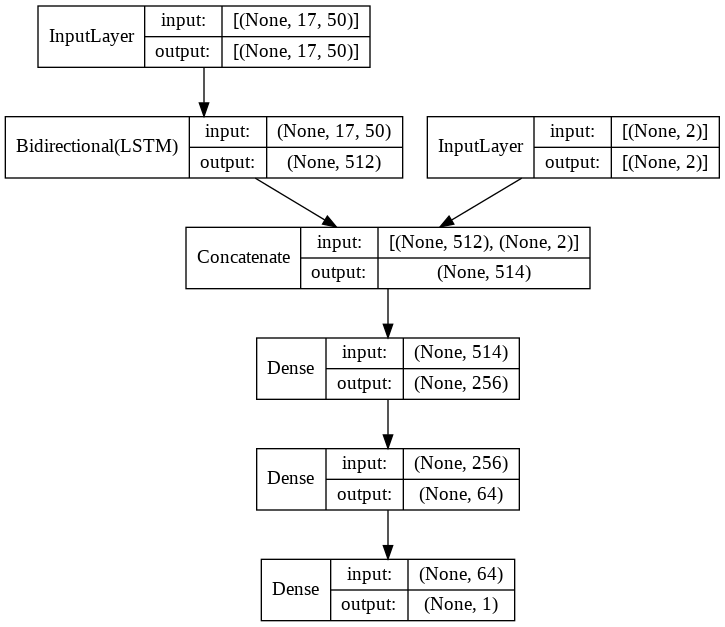

In [ ]:
print(model.summary())
plot_model(model, to_file=path+'/model 1/architecture.png', show_shapes=True, show_layer_names=False)

In [ ]:
model = load_model(checkpoint_filepath)
model.evaluate([X_test_lemma_OH, X_test_genRat], y_test_class)

35/35 [==============================] - 1s 6ms/step - loss: 0.1298 - accuracy: 0.9665


[0.1298159807920456, 0.9664551019668579]

In [ ]:
# model = load_model(checkpoint_filepath)
reportResult(model, history, [X_test_lemma_OH, X_test_genRat], y_test_class)

best model based on min test set loss:  acc= 0.9591659307479858  loss= 0.14375801384449005
best model based on max test set accuracy:  acc= 0.9617723822593689  loss= 0.16025805473327637

evaluate dataset with best model based on maximum test set accuracy
evaluate test set =  [0.1298159807920456, 0.9664551019668579]
35/35 [==============================] - 2s 5ms/step
------------------------------ metrics for test set ------------------------------
confusion matrix: 
 [[553  12]
 [ 25 513]]
              precision    recall  f1-score   support

      Broken      0.957     0.979     0.968       565
       Sound      0.977     0.954     0.965       538

    accuracy                          0.966      1103
   macro avg      0.967     0.966     0.966      1103
weighted avg      0.967     0.966     0.966      1103



# **Sequence to Sequence Models**

In [ ]:
path = '/content/drive/MyDrive/AI Projects/Arabic Broken Plural/Results/Machine Translation Models'

In [ ]:
lemma_length = X_train_lemma_OH.shape[1] #17
singularPattern_length = X_train_singularPattern_OH.shape[1] #17
root_length = X_train_root_OH.shape[1] #4
genRat_length = X_train_genRat.shape[1] #2
plPattern_length = y_train_plPattern_OH.shape[1] #18
inflection_length = y_train_inflection_OH.shape[1] #18
encode_size = X_train_lemma_OH.shape[2] #50

epochs = 100
batch_size = 64

## **Model 1**
lemma - inflection

In [ ]:
input_lemma = Input(shape=(lemma_length, encode_size))
input_root = Input(shape=(root_length, encode_size))
input_genRat = Input(shape=(genRat_length, ))


lstm1 = Bidirectional(LSTM(256))(input_lemma)
lstm2 = Bidirectional(LSTM(64))(input_root)

c = Concatenate(axis=1)([lstm1, lstm2])

d = Dense(254, activation='relu')(c)

c = Concatenate(axis=1)([d, input_genRat])

r = RepeatVector(inflection_length)(c)

lstm2 = Bidirectional(LSTM(256, return_sequences=True))(r)

output = TimeDistributed(Dense(encode_size, activation='softmax'))(lstm2)

model = Model(inputs=[input_lemma, input_root, input_genRat], outputs=output)

checkpoint_filepath = path + '/model 1/best model.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

model.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
  model.fit([X_train_lemma_OH, X_train_root_OH, X_train_genRat], y_train_inflection_OH, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_data=([X_dev_lemma_OH, X_dev_root_OH, X_dev_genRat], y_dev_inflection_OH))  # starts training

Epoch 1/100
45/45 [==============================] - 11s 69ms/step - loss: 0.0501 - accuracy: 0.5598 - val_loss: 0.0387 - val_accuracy: 0.6089
Epoch 2/100
45/45 [==============================] - 1s 24ms/step - loss: 0.0384 - accuracy: 0.6128 - val_loss: 0.0371 - val_accuracy: 0.6219
Epoch 3/100
45/45 [==============================] - 1s 24ms/step - loss: 0.0366 - accuracy: 0.6315 - val_loss: 0.0359 - val_accuracy: 0.6313
Epoch 4/100
45/45 [==============================] - 1s 24ms/step - loss: 0.0351 - accuracy: 0.6392 - val_loss: 0.0333 - val_accuracy: 0.6593
Epoch 5/100
45/45 [==============================] - 1s 21ms/step - loss: 0.0328 - accuracy: 0.6527 - val_loss: 0.0314 - val_accuracy: 0.6537
Epoch 6/100
45/45 [==============================] - 1s 24ms/step - loss: 0.0309 - accuracy: 0.6633 - val_loss: 0.0288 - val_accuracy: 0.6860
Epoch 7/100
45/45 [==============================] - 1s 24ms/step - loss: 0.0289 - accuracy: 0.6826 - val_loss: 0.0274 - val_accuracy: 0.7051
Epoch

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 17, 50)]     0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 4, 50)]      0           []                               
                                                                                                  
 bidirectional_12 (Bidirectiona  (None, 512)         628736      ['input_13[0][0]']               
 l)                                                                                               
                                                                                                  
 bidirectional_13 (Bidirectiona  (None, 128)         58880       ['input_14[0][0]']         

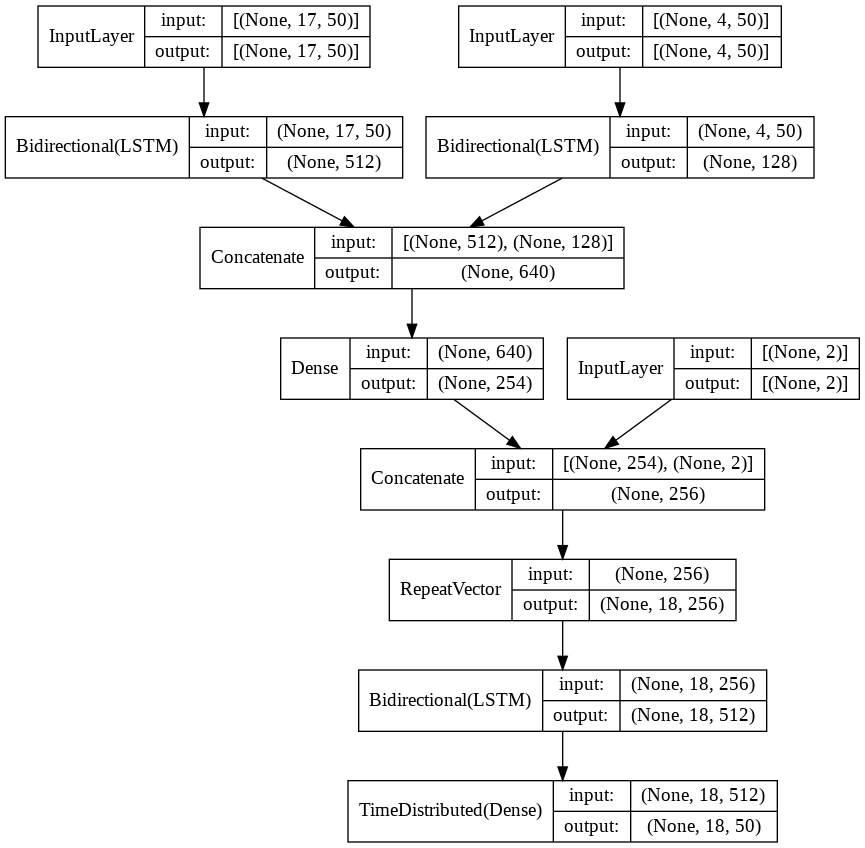

In [ ]:
print(model.summary())
plot_model(model, to_file=path+'/model 1/architecture.png', show_shapes=True, show_layer_names=False)

In [ ]:
model = load_model(checkpoint_filepath)
model.evaluate([X_test_lemma_OH, X_test_root_OH, X_test_genRat], y_test_inflection_OH)

35/35 [==============================] - 2s 8ms/step - loss: 0.0029 - accuracy: 0.9768


[0.0029138110112398863, 0.9767804741859436]

In [ ]:
print(X_test_lemma[0].shape)
# model.predict([X_test_lemma[0], X_test_root[0], X_test_genRat[0]])
# print(X_test_lemma[0])
print(model.predict([X_test_lemma_OH, X_test_root_OH, X_test_genRat])[0][0])
print(y_test_plPattern_OH[0][0])

(17,)
35/35 [==============================] - 3s 10ms/step
[1.2748498e-10 3.5702300e-04 3.8490716e-06 6.4264475e-07 4.7616364e-09
 1.0258235e-10 5.2070948e-11 8.2955906e-11 9.9963713e-01 2.5779093e-08
 2.3000210e-10 1.3913404e-09 1.5417875e-08 2.2417181e-08 1.0624085e-08
 4.0924469e-11 3.1951883e-10 2.6842162e-10 1.2414188e-07 4.5145748e-10
 4.0526125e-08 2.7450717e-11 4.7041221e-10 1.5894940e-09 9.1661700e-09
 4.1288657e-11 3.0942124e-11 1.0156181e-10 8.6808100e-08 1.1074150e-09
 2.3909765e-11 4.7508980e-08 6.7174369e-07 4.6569813e-08 3.8762957e-09
 1.9516870e-09 2.2543453e-08 8.2438003e-09 1.4628352e-11 2.8254396e-10
 1.7095272e-10 8.8803661e-12 3.2695646e-09 1.7424726e-07 8.7335257e-11
 6.3288895e-11 2.0795493e-10 2.1381332e-11 4.5976365e-12 1.6038676e-10]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


## **Model 2**
singular pattern - plural pattern

In [ ]:
input_singularPattern = Input(shape=(singularPattern_length, encode_size))
input_root = Input(shape=(root_length, encode_size))
input_genRat = Input(shape=(genRat_length, ))


lstm1 = Bidirectional(LSTM(256))(input_singularPattern)
lstm2 = Bidirectional(LSTM(64))(input_root)

c = Concatenate(axis=1)([lstm1, lstm2])

d = Dense(126, activation='relu')(c)

c = Concatenate(axis=1)([d, input_genRat])

r = RepeatVector(plPattern_length)(c)

lstm2 = Bidirectional(LSTM(256, return_sequences=True))(r)

output = TimeDistributed(Dense(encode_size, activation='softmax'))(lstm2)

model = Model(inputs=[input_singularPattern, input_root, input_genRat], outputs=output)

checkpoint_filepath = path + '/model 2/best model.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

model.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
  model.fit([X_train_singularPattern_OH, X_train_root_OH, X_train_genRat], y_train_plPattern_OH, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_data=([X_dev_singularPattern_OH, X_dev_root_OH, X_dev_genRat], y_dev_plPattern_OH))  # starts training

Epoch 1/100
45/45 [==============================] - 32s 68ms/step - loss: 0.0459 - accuracy: 0.5869 - val_loss: 0.0330 - val_accuracy: 0.6435
Epoch 2/100
45/45 [==============================] - 1s 24ms/step - loss: 0.0317 - accuracy: 0.6460 - val_loss: 0.0303 - val_accuracy: 0.6607
Epoch 3/100
45/45 [==============================] - 1s 24ms/step - loss: 0.0292 - accuracy: 0.6597 - val_loss: 0.0274 - val_accuracy: 0.6892
Epoch 4/100
45/45 [==============================] - 1s 25ms/step - loss: 0.0272 - accuracy: 0.6833 - val_loss: 0.0263 - val_accuracy: 0.6899
Epoch 5/100
45/45 [==============================] - 1s 23ms/step - loss: 0.0256 - accuracy: 0.7076 - val_loss: 0.0240 - val_accuracy: 0.7337
Epoch 6/100
45/45 [==============================] - 1s 24ms/step - loss: 0.0236 - accuracy: 0.7437 - val_loss: 0.0219 - val_accuracy: 0.7735
Epoch 7/100
45/45 [==============================] - 1s 23ms/step - loss: 0.0218 - accuracy: 0.7730 - val_loss: 0.0201 - val_accuracy: 0.7987
Epoch

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 17, 50)]     0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 4, 50)]      0           []                               
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 512)         628736      ['input_7[0][0]']                
 )                                                                                                
                                                                                                  
 bidirectional_7 (Bidirectional  (None, 128)         58880       ['input_8[0][0]']          

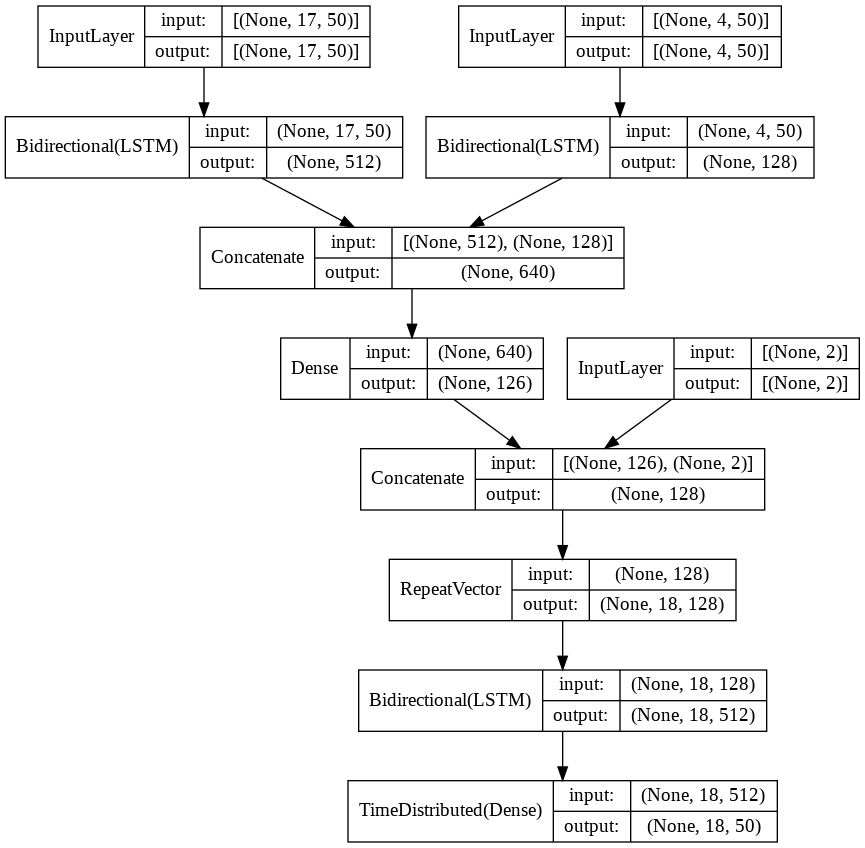

In [ ]:
print(model.summary())
plot_model(model, to_file=path+'/model 2/architecture.png', show_shapes=True, show_layer_names=False)

In [ ]:
model = load_model(checkpoint_filepath)
model.evaluate([X_test_singularPattern_OH, X_test_root_OH, X_test_genRat], y_test_plPattern_OH)

35/35 [==============================] - 3s 8ms/step - loss: 0.0032 - accuracy: 0.9720


[0.00318927806802094, 0.9719955921173096]

In [ ]:
print(X_test_lemma[0].shape)
# model.predict([X_test_lemma[0], X_test_root[0], X_test_genRat[0]])
# print(X_test_lemma[0])
print(model.predict([X_test_singularPattern_OH, X_test_root_OH, X_test_genRat])[0][0])
print(y_test_plPattern_OH[0][0])

(17,)
35/35 [==============================] - 2s 7ms/step
[5.7370623e-12 1.0980389e-12 8.3400295e-07 7.8603462e-06 2.8523041e-12
 3.7713637e-04 6.6480545e-12 5.3945724e-12 9.9961412e-01 1.1778167e-09
 7.7045745e-11 2.7127125e-11 2.2571427e-11 1.6857941e-12 4.6138988e-11
 9.8276747e-13 1.5673536e-10 9.1622359e-13 7.3303120e-13 2.7835562e-10
 4.2427585e-13 2.5386259e-11 9.6636566e-13 1.6266909e-13 5.6910615e-11
 1.4440752e-15 6.1325250e-13 1.2435667e-13 1.8882159e-12 2.4633852e-11
 2.2829042e-11 3.3860098e-10 2.2372101e-13 5.5367239e-10 1.3186399e-12
 9.3786708e-13 2.7099086e-08 3.3965192e-11 2.4851239e-13 3.6282140e-13
 5.3235840e-12 1.4910367e-13 1.7315217e-12 1.8464078e-12 3.7003445e-10
 6.7036491e-15 4.5374785e-13 1.7216421e-12 2.1772617e-11 1.7196272e-12]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


## **Model 3**
lemma - plural pattern

In [ ]:
input_lemma = Input(shape=(lemma_length, encode_size))
input_root = Input(shape=(root_length, encode_size))
input_genRat = Input(shape=(genRat_length, ))


lstm1 = Bidirectional(LSTM(256))(input_lemma)
lstm2 = Bidirectional(LSTM(128))(input_root)

c = Concatenate(axis=1)([lstm1, lstm2])

d = Dense(254, activation='relu')(c)

c = Concatenate(axis=1)([d, input_genRat])

r = RepeatVector(plPattern_length)(c)

lstm2 = Bidirectional(LSTM(256, return_sequences=True))(r)

output = TimeDistributed(Dense(encode_size, activation='softmax'))(lstm2)

model = Model(inputs=[input_lemma, input_root, input_genRat], outputs=output)

checkpoint_filepath = path + '/model 3/best model.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

model.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
  model.fit([X_train_lemma_OH, X_train_root_OH, X_train_genRat], y_train_plPattern_OH, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_data=([X_dev_lemma_OH, X_dev_root_OH, X_dev_genRat], y_dev_plPattern_OH))  # starts training

Epoch 1/100
45/45 [==============================] - 12s 71ms/step - loss: 0.0448 - accuracy: 0.5868 - val_loss: 0.0328 - val_accuracy: 0.6398
Epoch 2/100
45/45 [==============================] - 1s 24ms/step - loss: 0.0315 - accuracy: 0.6478 - val_loss: 0.0290 - val_accuracy: 0.6550
Epoch 3/100
45/45 [==============================] - 1s 24ms/step - loss: 0.0290 - accuracy: 0.6611 - val_loss: 0.0271 - val_accuracy: 0.6825
Epoch 4/100
45/45 [==============================] - 1s 24ms/step - loss: 0.0268 - accuracy: 0.6856 - val_loss: 0.0253 - val_accuracy: 0.7155
Epoch 5/100
45/45 [==============================] - 1s 24ms/step - loss: 0.0254 - accuracy: 0.7121 - val_loss: 0.0238 - val_accuracy: 0.7379
Epoch 6/100
45/45 [==============================] - 1s 22ms/step - loss: 0.0236 - accuracy: 0.7443 - val_loss: 0.0239 - val_accuracy: 0.7323
Epoch 7/100
45/45 [==============================] - 1s 25ms/step - loss: 0.0222 - accuracy: 0.7664 - val_loss: 0.0205 - val_accuracy: 0.7894
Epoch

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 17, 50)]     0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 4, 50)]      0           []                               
                                                                                                  
 bidirectional_9 (Bidirectional  (None, 512)         628736      ['input_10[0][0]']               
 )                                                                                                
                                                                                                  
 bidirectional_10 (Bidirectiona  (None, 256)         183296      ['input_11[0][0]']         

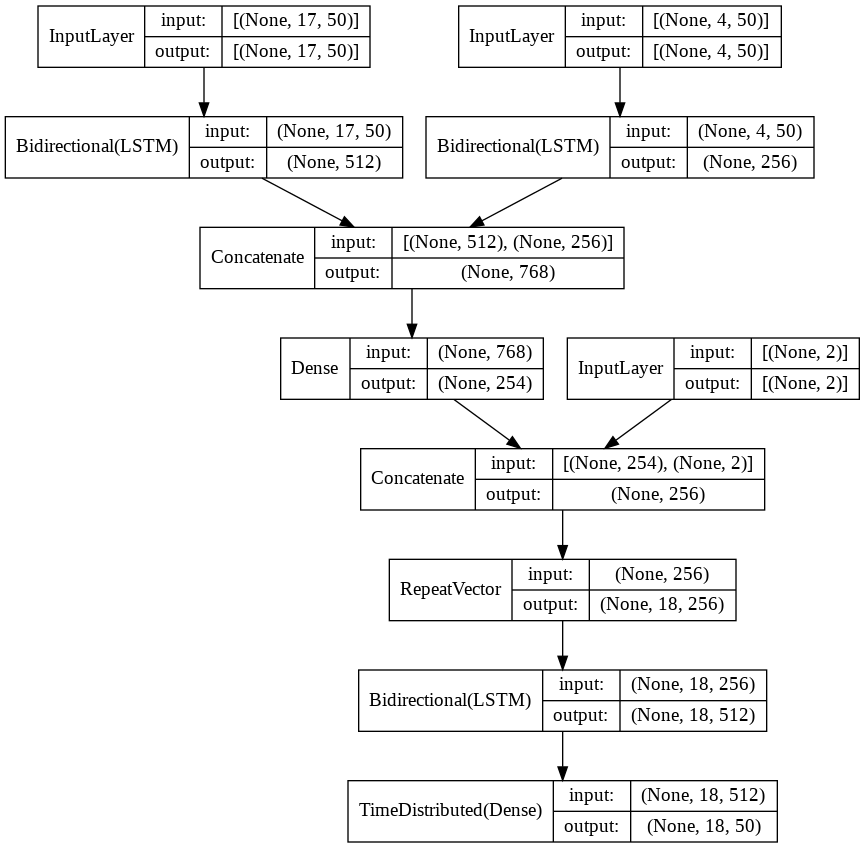

In [ ]:
print(model.summary())
plot_model(model, to_file=path+'/model 3/architecture.png', show_shapes=True, show_layer_names=False)

In [ ]:
model = load_model(checkpoint_filepath)
model.evaluate([X_test_lemma_OH, X_test_root_OH, X_test_genRat], y_test_plPattern_OH)

35/35 [==============================] - 2s 9ms/step - loss: 0.0033 - accuracy: 0.9729


[0.003287971718236804, 0.9729021787643433]

In [ ]:
print(X_test_lemma[0].shape)
# model.predict([X_test_lemma[0], X_test_root[0], X_test_genRat[0]])
# print(X_test_lemma[0])
print(model.predict([X_test_lemma_OH, X_test_root_OH, X_test_genRat])[0][0])
print(y_test_plPattern_OH[0][0])

(17,)
35/35 [==============================] - 2s 7ms/step
[5.18622645e-11 1.39061098e-11 8.46309092e-07 2.50800585e-05
 2.67867881e-11 6.14927895e-03 2.48377569e-10 5.61642226e-12
 9.93824720e-01 4.20564605e-09 4.55174148e-10 1.85091387e-11
 2.68174111e-11 2.13503833e-11 5.43945611e-10 1.04684164e-10
 5.89685467e-10 1.33712841e-11 3.88496423e-11 8.65599858e-09
 4.55859447e-11 4.92230090e-10 1.57491225e-11 4.96961456e-12
 1.61243119e-09 7.63328067e-14 3.61838823e-11 1.80313351e-11
 1.95747689e-11 1.86938815e-11 1.07509598e-10 1.84776250e-09
 3.03462117e-12 1.43482701e-08 3.51168747e-11 1.26599902e-11
 6.51771330e-08 8.98380884e-11 2.40771032e-11 2.31844214e-11
 2.71061108e-11 4.25094768e-12 8.39517518e-12 4.99288492e-11
 9.76700248e-11 1.04870458e-13 3.52255482e-11 4.38603945e-11
 1.87976752e-11 1.01810322e-11]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
